Adaptacion de modelo tomado de https://apmonitor.com/dde/index.php/Main/LLMTransformers con datos de Shanghai. Version 2

In [45]:
#Veamos si la grafica esta disponible
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 2060 SUPER


In [46]:
# Configurar el dispositivo GPU para utilizarlo en lugar del CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

Usando dispositivo: cuda


In [47]:
#Carguemos los datos
import pandas as pd
ShanghaiDat=pd.read_csv('Shanghai-2005-2025.csv')
ShanghaiDat=ShanghaiDat.drop(ShanghaiDat.columns[0], axis=1)

In [ ]:
#Debemos convertir nuestros datos en una ventana de datos deslizantes.
import numpy as np

# Convertimos los datos a un array de 1 dimension
ShanghaiDat = np.array(ShanghaiDat).flatten()

#Dividimos en epocas de 10 dias
def Epocas(sequence_length=12):
    size = len(ShanghaiDat) 
    sequences = [ShanghaiDat[i:i+sequence_length] for i in range(size-sequence_length)]
    next_points = ShanghaiDat[sequence_length:]

    # Convertir a NumPy arrays correctamente
    return np.array(sequences), np.array(next_points)

In [49]:
#Terminamos de cargar todas las librerias que vamos a usar
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, next_points):
        self.sequences = sequences
        self.next_points = next_points

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.next_points[idx]

In [ ]:
# Transformer Model (simplified for numerical data)
class TransformerModel(nn.Module):
    def __init__(self, input_size=1, sequence_length=12, num_layers=2, num_heads=4, dim_feedforward=512): #Se definen los parametros del modelo. Una capa, 2 cabezas de atencion
        super(TransformerModel, self).__init__() #Llama al init de la clase padre, que es el constructor del modelo. Es necesario para crear modelos personalizados
        self.sequence_length = sequence_length
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size*sequence_length, nhead=num_heads, dim_feedforward=dim_feedforward) #Define una capa
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers) #Crea el transformer definido anteriormente
        self.fc_out = nn.Linear(input_size * sequence_length, 1) #Capa fully connected que toma la salida del trandormer (10 valores) y regresa un unico valor (prediccion, next point)

    def forward(self, src):
        src = src.reshape(-1, self.sequence_length, 1) 
        src = src.flatten(start_dim=1) 
        src = src.unsqueeze(0) 
        out = self.transformer_encoder(src) 
        out = out.squeeze(0) 
        return self.fc_out(out) 

In [51]:
# Preparamos los datos
sequences, next_points = Epocas()
dataset = TimeSeriesDataset(sequences, next_points) 
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [52]:
#Entrenamiento del modelo
model = TransformerModel().to(device)
criterion = nn.MSELoss() #Funcion de perdida
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) #Optimizador

# Training loop
losses=[]
for epoch in range(300):
    for seq, next_point in dataloader:
        seq, next_point = seq.float().to(device), next_point.float().unsqueeze(1).to(device) 
        output = model(seq)
        loss = criterion(output, next_point) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    losses.append(loss)

C:\Users\Antonio Rojas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Loss: 10072106.0
Epoch 2, Loss: 8599422.0
Epoch 3, Loss: 9830664.0
Epoch 4, Loss: 8003208.5
Epoch 5, Loss: 9570472.0
Epoch 6, Loss: 9416982.0
Epoch 7, Loss: 9001998.0
Epoch 8, Loss: 8635203.0
Epoch 9, Loss: 9430201.0
Epoch 10, Loss: 7066335.0
Epoch 11, Loss: 6996355.0
Epoch 12, Loss: 7527640.5
Epoch 13, Loss: 9122519.0
Epoch 14, Loss: 7140640.0
Epoch 15, Loss: 5486275.5
Epoch 16, Loss: 9302100.0
Epoch 17, Loss: 7197495.5
Epoch 18, Loss: 7557576.5
Epoch 19, Loss: 8023291.0
Epoch 20, Loss: 8591555.0
Epoch 21, Loss: 8758243.0
Epoch 22, Loss: 7006049.0
Epoch 23, Loss: 5894240.0
Epoch 24, Loss: 7082052.5
Epoch 25, Loss: 5213872.0
Epoch 26, Loss: 7293057.5
Epoch 27, Loss: 5712044.0
Epoch 28, Loss: 4265209.5
Epoch 29, Loss: 7280618.0
Epoch 30, Loss: 5295829.0
Epoch 31, Loss: 6215222.5
Epoch 32, Loss: 5469889.5
Epoch 33, Loss: 4797069.0
Epoch 34, Loss: 8911084.0
Epoch 35, Loss: 5392572.0
Epoch 36, Loss: 5451357.5
Epoch 37, Loss: 3331470.25
Epoch 38, Loss: 6771070.5
Epoch 39, Loss: 532

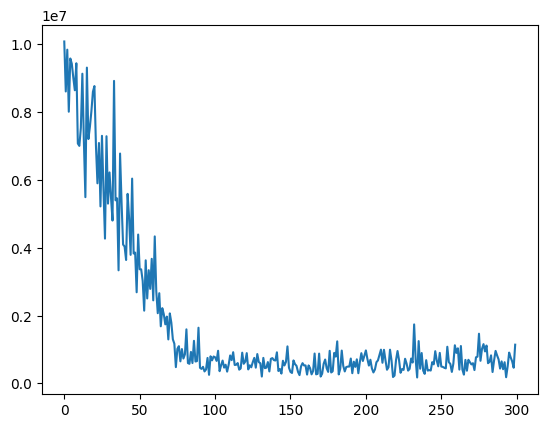

In [53]:
import matplotlib.pyplot as plt

losses = [loss.detach().cpu().item() for loss in losses]
losses = np.array(losses)

plt.plot(losses)
plt.show()

In [54]:
test_seq = torch.tensor(sequences[0]).float()
test_seq = test_seq.unsqueeze(0) 
test_seq = test_seq.to(device)
with torch.no_grad():
    predicted_point = model(test_seq)
print("Prediccion(dato siguiente):", predicted_point.item())
print('Dato siguiente real:',next_points[0])


Prediccion(dato siguiente): 2867.02099609375
Dato siguiente real: 1278.8800048828125
